# CIFAR10 with MLPs
Simple starter notebook to benchmark your own MLP with PyTorch on the CIFAR-10 dataset.

OBS.:

- The main code is basically done, so focus on training the models and searching for the best hyperparameters and architectures.
- You are not required to use this exact code or even the PyTorch library.
- It is recommended to use execution environments with GPU access (such as Google Colab), since larger models will take more time to train.
- Remember to document the history of your experiments and which results motivated the changes in subsequent experiments.

## Como tentamos melhorar o modelo:
- Utilizamos o optuna para encontrar melhores hiperparâmetros: learning rate, número de nós em cada camada e função de ativação
- Evitar overfiting:
    - Regularização com weight_decay no otimizador para diminuir a magnitude dos pesos
    - Uso de dropout para desativar 20% dos neurônios
    - separação do dataset de treinamento em treinamento e validação
    - Uso de early stopping levando em conta o loss da validação

In [ ]:
%pip install optuna
%pip install torch
%pip install torchvision
%pip install scikit-learn
%pip install matplotlib
%pip install numpy
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


In [2]:
#@title Libs

import torch 
from torch.utils.data import DataLoader

import torchvision
import torch.nn as nn
from torchvision import datasets, transforms

from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset

import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

from tqdm import tqdm

import os
from collections import Counter

import optuna

c:\Users\anaso\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data exploration

Quando usamos transforms.ToTensor(), a imagem (que antes era H x W x C) vira um tensor com shape: C x H x W

O matplotlib.pyplot.imshow() espera a imagem no formato H x W x C (como a maioria das bibliotecas de imagem em Python).


In [3]:
# Função para "desnormalizar" e mostrar imagens
def imshow(img):
    img = img / 2 + 0.5  # desfaz a normalização
    img = torch.clamp(img, 0, 1)  # limita os valores ao intervalo [0, 1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  
])

dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform= transform)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

100%|██████████| 170M/170M [00:10<00:00, 16.4MB/s] 


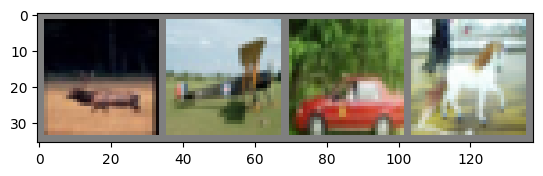

deer airplane automobile horse


In [5]:
# Itera no loader e mostra imagens
dataiter = iter(loader)
images, labels = next(dataiter)

# Mostra as imagens
imshow(torchvision.utils.make_grid(images))

# Mostra os rótulos correspondentes
print(' '.join(f'{dataset.classes[label]}' for label in labels))

In [6]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [7]:
# Extraímos todos os rótulos do dataset de treino e ignoramos as imagens
labels = [label for _, label in dataset]

# Contamos quantas vezes cada rótulo aparece
label_counts = Counter(labels)

# Imprimimos o resultado com nome da classe
for class_idx, count in label_counts.items():
    class_name = dataset.classes[class_idx]
    print(f'{class_name}: {count} imagens')

frog: 5000 imagens
truck: 5000 imagens
deer: 5000 imagens
automobile: 5000 imagens
bird: 5000 imagens
horse: 5000 imagens
ship: 5000 imagens
cat: 5000 imagens
dog: 5000 imagens
airplane: 5000 imagens


Scores of the first model:
  'accuracy': 0.474, 'balanced_accuracy': np.float64(0.47400000000000003), 'precision': 0.4788458695520801, 'recall': 0.474, 'f1_score': 0.4749641894435279



Começamos a treinar uma mlp com 4 camadas usando imagens com 3 canais (RGB) , depois transformamos as imagens para a escala de cinza

In [8]:
#@title Defining the MLP model

class MLP(nn.Module):
    def __init__(self, input_size, hidden1, hidden2, num_classes, activation_function):
        super(MLP, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(input_size, hidden1),
            activation_function,
            nn.Dropout(0.2),
            nn.Linear(hidden1, hidden2),
            activation_function,
            nn.Dropout(0.2),
            nn.Linear(hidden2, num_classes)
        )

    def forward(self, x):
        return self.network(x)

## Hyperparameters Study



In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def objective(trial):

    # Hiperparâmetros sugeridos pelo Optuna
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    hidden1 = trial.suggest_int("hidden1", 64, 256)
    hidden2 = trial.suggest_int("hidden2", 64, 256)
    activation_name = trial.suggest_categorical("activation", ["ReLU", "LeakyReLU", "ELU"])

    activation_fn = getattr(nn, activation_name)()

    # Dataset e DataLoader (usa apenas um subset para acelerar)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    val_dataset, _ = torch.utils.data.random_split(train_dataset, [5000, len(train_dataset)-5000])
    train_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

    model = MLP(32*32*3,
                hidden1= hidden1,
                hidden2= hidden2,
                num_classes = 10,
                activation_function = activation_fn)

    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Treinamento simples de 1-3 épocas (rápido)
    for epoch in range(3):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.view(-1, 32*32*3).to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

    # Retorna a perda média como métrica a minimizar
    return running_loss / len(train_loader)

In [10]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

[I 2025-05-31 16:05:07,857] A new study created in memory with name: no-name-fcc6b38c-0eb7-49f3-bb88-4fb9310cfb51
[I 2025-05-31 16:05:14,753] Trial 0 finished with value: 1.753482859345931 and parameters: {'lr': 0.0005327036667632498, 'hidden1': 118, 'hidden2': 67, 'activation': 'LeakyReLU'}. Best is trial 0 with value: 1.753482859345931.
[I 2025-05-31 16:05:21,363] Trial 1 finished with value: 1.6457125205027907 and parameters: {'lr': 0.0010192132541430078, 'hidden1': 186, 'hidden2': 105, 'activation': 'ReLU'}. Best is trial 1 with value: 1.6457125205027907.
[I 2025-05-31 16:05:28,781] Trial 2 finished with value: 1.917522689964198 and parameters: {'lr': 9.640445097076418e-05, 'hidden1': 78, 'hidden2': 228, 'activation': 'LeakyReLU'}. Best is trial 1 with value: 1.6457125205027907.
[I 2025-05-31 16:05:35,010] Trial 3 finished with value: 1.8443338116513024 and parameters: {'lr': 9.575655114446811e-05, 'hidden1': 195, 'hidden2': 106, 'activation': 'ReLU'}. Best is trial 1 with value: 1

In [11]:
print("Melhores hiperparâmetros:")
print(study.best_params)

Melhores hiperparâmetros:
{'lr': 0.0007881996634636053, 'hidden1': 231, 'hidden2': 253, 'activation': 'ELU'}


In [19]:
#@title Hyperparameters
input_size = 32*32*3 # 32x32 RGB images
num_classes = 10

learning_rate = 0.0007
num_epochs = 30
batch_size = 16
hidden1 = 231
hidden2 = 253

activation_function = nn.ELU()

loss_function = nn.CrossEntropyLoss()

In [20]:
#@title Dataset Setup

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_val_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


In [21]:
def evaluate(model, val_loader, loss_function):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.view(-1, 32*32*3).to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
    model.train()
    return val_loss / len(val_loader)

In [22]:
# Extrai os rótulos
targets = np.array(train_val_dataset.targets)

# Cria o validador estratificado
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Gera os índices
for train_idx, val_idx in splitter.split(np.zeros(len(targets)), targets):
    train_dataset = Subset(train_val_dataset, train_idx)
    val_dataset = Subset(train_val_dataset, val_idx)

In [23]:
# Acessa os rótulos (targets) do val_dataset
val_targets = [train_val_dataset[idx][1] for idx in val_dataset.indices]

# Conta quantas vezes cada classe aparece
val_distribution = Counter(val_targets)

print("Distribuição de classes no val_dataset:")
for label, count in sorted(val_distribution.items()):
    print(f"Classe {label}: {count} amostras")

Distribuição de classes no val_dataset:
Classe 0: 1000 amostras
Classe 1: 1000 amostras
Classe 2: 1000 amostras
Classe 3: 1000 amostras
Classe 4: 1000 amostras
Classe 5: 1000 amostras
Classe 6: 1000 amostras
Classe 7: 1000 amostras
Classe 8: 1000 amostras
Classe 9: 1000 amostras


In [24]:
#@title Loaders

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [25]:
#@title Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Build the model
mlp = MLP(32*32*3,
                hidden1= hidden1,
                hidden2= hidden2,
                num_classes = 10,
                activation_function = activation_function)
mlp.to(device)

# Setting optimizer up
optimizer = torch.optim.AdamW(mlp.parameters(), lr=learning_rate, weight_decay = 1e-4)

# Early stopping setup
best_loss = float('inf')
patience = 5
patience_counter = 0
best_model_state = None

train_losses = []
val_losses = []

# Start training epochs loop
for epoch in tqdm(range(num_epochs)):
  epoch_loss = 0.0
  for i, (images, labels) in enumerate(train_loader):
    images = images.view(-1,32*32*3).to(device) # flattenning images
    labels = labels.to(device)

    # Forward pass
    optimizer.zero_grad()
    outputs = mlp(images)

    # Backward pass
    loss = loss_function(outputs, labels)
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

    if (i+1) % 1000 == 0:
      tqdm.write(f' Epoch {epoch + 1}/{num_epochs}, Step {i+1}/{len(train_dataset) // batch_size}, Loss: {loss}')

  epoch_loss /= len(train_loader)
  tqdm.write(f'Epoch {epoch+1} average loss: {epoch_loss:.4f}')
  train_losses.append(epoch_loss)

  val_loss = evaluate(mlp, val_loader, loss_function)
  tqdm.write(f'Epoch {epoch+1} validation loss: {val_loss:.4f}')
  val_losses.append(val_loss)

  # Early stopping using loss value
  if val_loss < best_loss:
    best_loss = val_loss
    patience_counter = 0
    best_model_state = mlp.state_dict()
  else:
    patience_counter += 1
    if patience_counter >= patience:
      tqdm.write("Early stopping triggered.")
      break

if best_model_state is not None:
    mlp.load_state_dict(best_model_state)
    torch.save(mlp.state_dict(), "melhor_modelo.pth")


  0%|          | 0/30 [00:16<?, ?it/s]

 Epoch 1/30, Step 1000/2500, Loss: 1.9184983968734741


  0%|          | 0/30 [00:32<?, ?it/s]

 Epoch 1/30, Step 2000/2500, Loss: 1.4398701190948486


  0%|          | 0/30 [00:40<?, ?it/s]

Epoch 1 average loss: 1.7143


  3%|▎         | 1/30 [00:44<21:34, 44.63s/it]

Epoch 1 validation loss: 1.5713


  3%|▎         | 1/30 [01:00<21:34, 44.63s/it]

 Epoch 2/30, Step 1000/2500, Loss: 1.3480767011642456


  3%|▎         | 1/30 [01:16<21:34, 44.63s/it]

 Epoch 2/30, Step 2000/2500, Loss: 1.3839051723480225


  3%|▎         | 1/30 [01:23<21:34, 44.63s/it]

Epoch 2 average loss: 1.5440


  7%|▋         | 2/30 [01:26<20:07, 43.12s/it]

Epoch 2 validation loss: 1.4750


  7%|▋         | 2/30 [01:42<20:07, 43.12s/it]

 Epoch 3/30, Step 1000/2500, Loss: 1.1840499639511108


  7%|▋         | 2/30 [01:56<20:07, 43.12s/it]

 Epoch 3/30, Step 2000/2500, Loss: 1.3716251850128174


  7%|▋         | 2/30 [02:04<20:07, 43.12s/it]

Epoch 3 average loss: 1.4669


 10%|█         | 3/30 [02:07<18:53, 42.00s/it]

Epoch 3 validation loss: 1.4690


 10%|█         | 3/30 [02:20<18:53, 42.00s/it]

 Epoch 4/30, Step 1000/2500, Loss: 1.6387979984283447


 10%|█         | 3/30 [02:35<18:53, 42.00s/it]

 Epoch 4/30, Step 2000/2500, Loss: 1.7782464027404785


 10%|█         | 3/30 [02:43<18:53, 42.00s/it]

Epoch 4 average loss: 1.4095


 13%|█▎        | 4/30 [02:47<17:50, 41.15s/it]

Epoch 4 validation loss: 1.4495


 13%|█▎        | 4/30 [03:02<17:50, 41.15s/it]

 Epoch 5/30, Step 1000/2500, Loss: 1.383375644683838


 13%|█▎        | 4/30 [03:17<17:50, 41.15s/it]

 Epoch 5/30, Step 2000/2500, Loss: 0.7733078002929688


 13%|█▎        | 4/30 [03:25<17:50, 41.15s/it]

Epoch 5 average loss: 1.3642


 17%|█▋        | 5/30 [03:29<17:15, 41.41s/it]

Epoch 5 validation loss: 1.3935


 17%|█▋        | 5/30 [03:43<17:15, 41.41s/it]

 Epoch 6/30, Step 1000/2500, Loss: 1.0162593126296997


 17%|█▋        | 5/30 [04:01<17:15, 41.41s/it]

 Epoch 6/30, Step 2000/2500, Loss: 1.3943172693252563


 17%|█▋        | 5/30 [04:10<17:15, 41.41s/it]

Epoch 6 average loss: 1.3241


 20%|██        | 6/30 [04:14<17:07, 42.80s/it]

Epoch 6 validation loss: 1.3938


 20%|██        | 6/30 [04:33<17:07, 42.80s/it]

 Epoch 7/30, Step 1000/2500, Loss: 1.0782444477081299


 20%|██        | 6/30 [04:51<17:07, 42.80s/it]

 Epoch 7/30, Step 2000/2500, Loss: 0.8960513472557068


 20%|██        | 6/30 [05:00<17:07, 42.80s/it]

Epoch 7 average loss: 1.2952


 23%|██▎       | 7/30 [05:04<17:20, 45.23s/it]

Epoch 7 validation loss: 1.3797


 23%|██▎       | 7/30 [05:22<17:20, 45.23s/it]

 Epoch 8/30, Step 1000/2500, Loss: 0.9977728724479675


 23%|██▎       | 7/30 [05:39<17:20, 45.23s/it]

 Epoch 8/30, Step 2000/2500, Loss: 1.0750291347503662


 23%|██▎       | 7/30 [05:48<17:20, 45.23s/it]

Epoch 8 average loss: 1.2571


 27%|██▋       | 8/30 [05:52<16:55, 46.15s/it]

Epoch 8 validation loss: 1.3827


 27%|██▋       | 8/30 [06:10<16:55, 46.15s/it]

 Epoch 9/30, Step 1000/2500, Loss: 0.7323523163795471


 27%|██▋       | 8/30 [06:28<16:55, 46.15s/it]

 Epoch 9/30, Step 2000/2500, Loss: 1.3071883916854858


 27%|██▋       | 8/30 [06:37<16:55, 46.15s/it]

Epoch 9 average loss: 1.2292


 30%|███       | 9/30 [06:41<16:26, 46.97s/it]

Epoch 9 validation loss: 1.3838


 30%|███       | 9/30 [06:57<16:26, 46.97s/it]

 Epoch 10/30, Step 1000/2500, Loss: 1.2234749794006348


 30%|███       | 9/30 [07:10<16:26, 46.97s/it]

 Epoch 10/30, Step 2000/2500, Loss: 1.235769271850586


 30%|███       | 9/30 [07:18<16:26, 46.97s/it]

Epoch 10 average loss: 1.2078


 33%|███▎      | 10/30 [07:21<14:57, 44.89s/it]

Epoch 10 validation loss: 1.3669


 33%|███▎      | 10/30 [07:36<14:57, 44.89s/it]

 Epoch 11/30, Step 1000/2500, Loss: 1.8212642669677734


 33%|███▎      | 10/30 [07:51<14:57, 44.89s/it]

 Epoch 11/30, Step 2000/2500, Loss: 1.5856726169586182


 33%|███▎      | 10/30 [07:58<14:57, 44.89s/it]

Epoch 11 average loss: 1.1878


 37%|███▋      | 11/30 [08:02<13:46, 43.50s/it]

Epoch 11 validation loss: 1.3788


 37%|███▋      | 11/30 [08:20<13:46, 43.50s/it]

 Epoch 12/30, Step 1000/2500, Loss: 1.500320553779602


 37%|███▋      | 11/30 [08:40<13:46, 43.50s/it]

 Epoch 12/30, Step 2000/2500, Loss: 1.3681526184082031


 37%|███▋      | 11/30 [08:50<13:46, 43.50s/it]

Epoch 12 average loss: 1.1591


 40%|████      | 12/30 [08:55<13:54, 46.35s/it]

Epoch 12 validation loss: 1.3918


 40%|████      | 12/30 [09:16<13:54, 46.35s/it]

 Epoch 13/30, Step 1000/2500, Loss: 1.7027229070663452


 40%|████      | 12/30 [09:39<13:54, 46.35s/it]

 Epoch 13/30, Step 2000/2500, Loss: 0.7232646346092224


 40%|████      | 12/30 [09:50<13:54, 46.35s/it]

Epoch 13 average loss: 1.1406


 43%|████▎     | 13/30 [09:54<14:13, 50.21s/it]

Epoch 13 validation loss: 1.3827


 43%|████▎     | 13/30 [10:08<14:13, 50.21s/it]

 Epoch 14/30, Step 1000/2500, Loss: 1.2027333974838257


 43%|████▎     | 13/30 [10:24<14:13, 50.21s/it]

 Epoch 14/30, Step 2000/2500, Loss: 1.1786515712738037


 43%|████▎     | 13/30 [10:32<14:13, 50.21s/it]

Epoch 14 average loss: 1.1273


 47%|████▋     | 14/30 [10:36<12:44, 47.76s/it]

Epoch 14 validation loss: 1.3816


 47%|████▋     | 14/30 [10:53<12:44, 47.76s/it]

 Epoch 15/30, Step 1000/2500, Loss: 0.8017592430114746


 47%|████▋     | 14/30 [11:09<12:44, 47.76s/it]

 Epoch 15/30, Step 2000/2500, Loss: 0.8045498132705688


 47%|████▋     | 14/30 [11:17<12:44, 47.76s/it]

Epoch 15 average loss: 1.1058


 47%|████▋     | 14/30 [11:21<12:58, 48.66s/it]

Epoch 15 validation loss: 1.3803
Early stopping triggered.


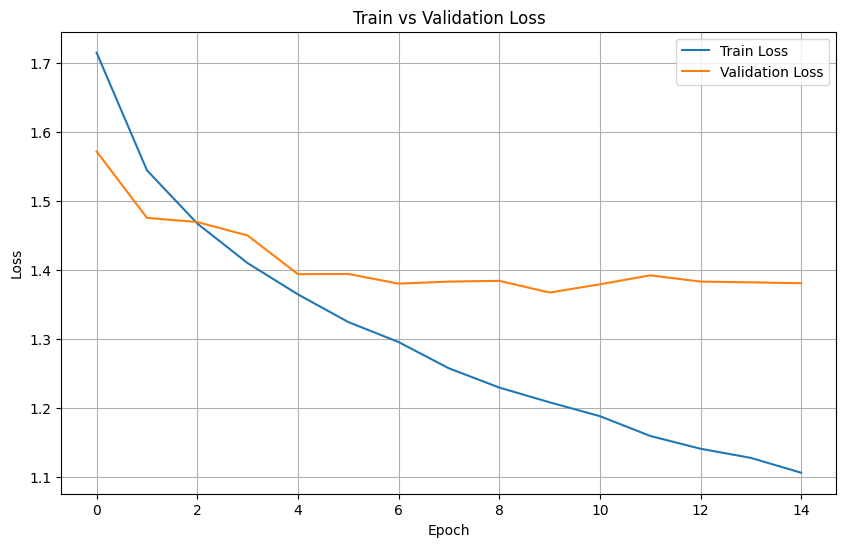

In [26]:
plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
print(device)

cpu


In [28]:
#@title Defining metrics helper

def get_scores(targets, predictions):
    return {
        "accuracy": metrics.accuracy_score(targets, predictions),
        "balanced_accuracy": metrics.balanced_accuracy_score(targets, predictions),
        "precision": metrics.precision_score(targets, predictions, average="weighted"),
        "recall": metrics.recall_score(targets, predictions, average="weighted"),
        "f1_score": metrics.f1_score(targets, predictions, average="weighted")
    }

In [29]:
#@title Evaluate model (accuracy, precision, recall)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mlp = MLP(32*32*3,
          hidden1= hidden1,
          hidden2= hidden2,
          num_classes = 10,
          activation_function = activation_function)

mlp.to(device)

if os.path.exists("melhor_modelo.pth"):
    mlp.load_state_dict(torch.load("melhor_modelo.pth"))
    print("Pesos carregados com sucesso.")
else:
    print("Arquivo de pesos não encontrado. Modelo será inicializado do zero.")

mlp.eval()
predictions = []
labels = []
for images, label in val_loader:
  images = images.view(-1,32*32*3).to(device)
  label = label.to(device)

  output = mlp(images)
  _, predicted = torch.max(output,1)

  predictions.extend(predicted.cpu().numpy())
  labels.extend(label.cpu().numpy())

scores = get_scores(labels, predictions)
print("Scores of your model\n", scores)

Pesos carregados com sucesso.
Scores of your model
 {'accuracy': 0.5191, 'balanced_accuracy': np.float64(0.5191000000000001), 'precision': 0.5352035101686355, 'recall': 0.5191, 'f1_score': 0.5190616927825459}


# You can change/optimize this as you want
- Different optimizers, activation functions, etc
- Automatic hyperparameters optimization (Optuna)
- Regularization techniques
- Validation set to track metrics during epochs
- Transform input data
- ...